In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:

path_to_your_folder =  "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv" #edit with your own path
%cd $path_to_your_folder



In [3]:
import sys
sys.path.append("./utils")
sys.path.append("./helpers")


In [4]:
PARAMS = {
  'MODELS' : ["Unet"], # Available : "Unet","DeepLabV3","FPN",
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 2,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : False, #choose whether the data is augmented to 900 images or use original dataset of 100 images,
  'CLASSES' : ['road'],
}


In [5]:
from IPython.display import clear_output


In [6]:

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from save_training_results import save_results
from mask_to_submission import masks_to_submission





In [8]:
#Creates the necessary folders for saving results

model_weights_folder = './results/model_weights/'
os.makedirs(model_weights_folder, exist_ok=True)

submission_folder = './submissions/eval_imgs/'
os.makedirs(submission_folder, exist_ok=True)

In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = [ 'road', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #try using 416 pixels
        image = cv2.resize(image, (416, 416))
        mask = cv2.imread(self.masks_fps[i],0)
        mask = cv2.resize(mask, (416, 416))

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [10]:
models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]

preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])

In [11]:

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [12]:
# import sys
# sys.path.append('./utils/')
# from data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset

# # Create folders for data augmentation
# %mkdir data/data_train_augmented
# %mkdir data/data_train_augmented/images/
# %mkdir data/data_train_augmented/masks/
# %mkdir data/data_train_augmented/raw/
# %mkdir data/data_train_augmented/raw/images/
# %mkdir data/data_train_augmented/raw/masks/
# %mkdir data/data_validation
# %mkdir data/data_validation/images/
# %mkdir data/data_validation/masks/
# %mkdir data/data_validation/raw/
# %mkdir data/data_validation/raw/images/
# %mkdir data/data_validation/raw/masks/

# # Load images and masks from dataset
# PATH_IMG_TRAIN = "./data/training/images/"
# PATH_MASK_TRAIN = "./data/training/groundtruth/"
# img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
# key_list = list(img_train.keys())
# key_list.sort()

# # Split the images for training/validation (+ store)
# training_ratio = 0.8
# seed = 1
# train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

# PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
# PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
# PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
# PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

# store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
# store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
# store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
# store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

# MASK_THRESHOLD = 120
# SIZE_X = 416 #divisible by 32
# SIZE_Y = 416 #divisible by 32
# PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
# PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
# PATH_VAL_IMG = "./data/data_validation/images/"
# PATH_VAL_MASK = "./data/data_validation/masks/"

# # Load validation images and resize
# img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
# keys_val = list(img_val_raw.keys())
# resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

# # Load training images, resize and augment using geometric transformation (+ store)
# img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
# keys_tr = list(img_tr_raw.keys())
# resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

In [13]:
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_VAL_IMG = "./data/data_validation/images/"
PATH_VAL_MASK = "./data/data_validation/masks/"


#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
train_dataset = Dataset(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)



In [14]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp_utils.losses.DiceLoss()
# metrics = [
#     smp_utils.metrics.IoU(threshold=0.5),
#     smp_utils.metrics.Fscore(),
# ]
#myinstance.__class__.__name__

loss_fn = smp.losses.dice.DiceLoss(mode ='binary')
loss_fn.__name__ = 'Dice_loss'

metrics = [
      smp_utils.metrics.Fscore(), ]

Unet

Epoch: 0
valid: 100%|██████████| 16/16 [00:02<00:00,  6.70it/s, Dice_loss - 0.5773, fscore - 0.05737]
{'Dice_loss': 0.5772649124264716, 'fscore': 0.057366261069546454}
Model saved!

Epoch: 1
valid: 100%|██████████| 16/16 [00:01<00:00, 13.21it/s, Dice_loss - 0.4504, fscore - 0.3806]
{'Dice_loss': 0.4503812789916992, 'fscore': 0.38060746976407245}
Model saved!
test


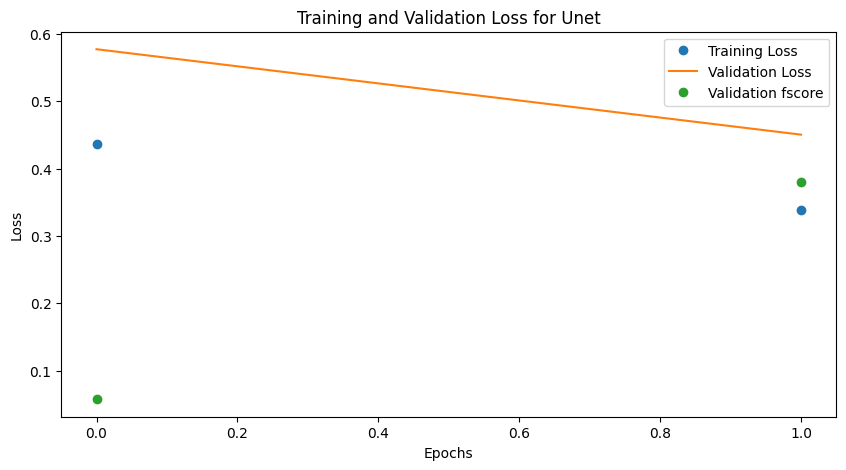

In [15]:
# train model for NB_EPOCHS



for model,model_name in models:
  print(model_name)
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss_fn,
      metrics=metrics,
      optimizer=optimizer,
      device="cuda",
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss_fn,
      metrics=metrics,
      device="cuda",
      verbose=True,
  )


  max_score = 0
  train_loss_array = []
  validation_loss_array = []
  validation_fscore_array = []



  for i in range(0, PARAMS["NB_EPOCHS"]):

      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)

      train_loss_array.append(train_logs["Dice_loss"])
      validation_loss_array.append(valid_logs["Dice_loss"])
      validation_fscore_array.append(valid_logs["fscore"])
      print(valid_logs)
      # do something (save model, change lr, etc.)
      if max_score < valid_logs['fscore']:
          max_score = valid_logs['fscore']
          torch.save(model, model_weights_folder + 'best_model_{}.pth'.format(model_name))
          print('Model saved!')

      if i == 25:
          optimizer.param_groups[0]['lr'] = 1e-5
          print('Decrease decoder learning rate to 1e-5!')
  epochs = range(0,len(train_loss_array))

  save_results(PARAMS,train_loss_array,validation_loss_array,validation_fscore_array)


  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_loss_array,"o", label='Training Loss')
  plt.plot(epochs, validation_loss_array,  label='Validation Loss')
  plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
  plt.title('Training and Validation Loss for {}'.format(model_name))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()





# II) Submission

---



In [16]:

MODEL_NAME = "Unet"
MODEL_PATH = model_weights_folder + 'best_model_{}.pth'.format(MODEL_NAME)
DEVICE ='cuda'

test_model = torch.load(MODEL_PATH)


### Test

In [17]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    masks_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

#not working for me already had this error. was dataset class modified?


In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from PIL import Image


def visualize(pr_mask, quiet=True):
  if quiet: return

  # Plot the histogram of the pixel values
  plt.figure()
  plt.hist(pr_mask.flatten(), bins=30, alpha=0.7, color='blue', edgecolor='black')
  plt.title('Histogram of Pixel Values')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

  #Show the image
  plt.figure()
  plt.imshow(pr_mask,cmap='gray')

  plt.figure()
  plt.imshow(gt_mask.squeeze())

  plt.show()

for count in range(0,50):

  image, gt_mask = test_dataset[count]

  input_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  pr_mask = test_model.predict(input_tensor)
  pr_mask = torch.sigmoid(pr_mask)


  pr_mask = (pr_mask.squeeze().cpu().numpy().round())

  #visualize if you like
  visualize(pr_mask,quiet=False)

  image_data = np.uint8(pr_mask * 255)  # Convert to 0-255 pixel values
  image = Image.fromarray(image_data, 'L')  # Create an image in grayscale (L mode)

  # Resize the PIL image to 608x608
  image_resized = image.resize((608, 608), Image.NEAREST)
    # Save the image
  image_num = count + 1
  #display(image_resized)
  filename = "test_eval_" + '%.3d' % image_num + '.png'
  image_resized.save(os.path.join(submission_folder, filename))
  # print(f"Saved {filename}")


In [22]:
SUBMISSION_PATH = "./submissions/"
submission_filename = SUBMISSION_PATH + 'test_submission.csv'
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = SUBMISSION_PATH + 'eval_imgs/test_eval_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)
